In [3]:
import numpy as np  
import pandas as pd
import os
import re
from random import shuffle
from keras.preprocessing import sequence

In [4]:
def text_cleaner(text):
    text = text.lower()
    text = re.sub(r"[.,\")(>+<*/]", " ", text)
    text = re.sub(r"[']", "", text)
    text = re.sub(r"[!]", " !", text)
    return re.sub(r"[?]", " ?", text)

def rate_cleaner(rate):
    if int(rate[rate.index('_') + 1 : rate.index('.')]) >= 6:
        return 1
    else: 
        return 0

def text_transformer(text, vocabulary):
    cleaned_text = text_cleaner(text).split()
    for word in range(len(cleaned_text)):
        cleaned_text[word] = vocabulary[cleaned_text[word]] if vocabulary.get(cleaned_text[word]) != None else 0
    return cleaned_text

def file_reader(dir_name, vocabulary):
    vector = []
    rate = []
    
    for name in os.listdir(dir_name):
        if name != '.ipynb_checkpoints':
            with open(os.path.join(dir_name, name), 'r') as file:
                rate.append(rate_cleaner(name))
                text = file.read()
                vector.append(text_transformer(text, vocabulary))
            
    return vector, rate

def pad_sequences(arr, maxlen):
    for i in range(len(arr)):
        if len(arr[i]) < maxlen: 
            arr[i] += [0 for x in range(maxlen - len(arr[i]))]
        elif len(arr[i]) > maxlen:
            arr[i] = arr[i][:maxlen] 
        arr[i] = np.array(arr[i])
    return arr

In [5]:
vocabulary_numbs = {}

number = 1

with open('imdb.vocab', 'r') as file_handler:
    for word in file_handler:
        vocabulary_numbs[word.strip()] = number
        number += 1
        
vector_neg_train, rate_neg_train = file_reader('neg_train', vocabulary_numbs)
vector_pos_train, rate_pos_train = file_reader('pos_train', vocabulary_numbs)
vector_neg_test, rate_neg_test = file_reader('neg_test', vocabulary_numbs)
vector_pos_test, rate_pos_test = file_reader('pos_test', vocabulary_numbs)

x_train, y_train = vector_neg_train + vector_pos_train, rate_neg_train + rate_pos_train
x_test, y_test = vector_neg_test + vector_pos_test, rate_neg_test + rate_pos_test

train = pd.DataFrame({'X': x_train, 'y' : y_train}).sample(frac=1)
test = pd.DataFrame({'X': x_test, 'y': y_test}).sample(frac=1)

In [6]:
x_train, y_train = np.array(train.X), np.array(train.y)
x_test, y_test = np.array(test.X), np.array(test.y)

max_review_length = 300
x_train = sequence.pad_sequences(x_train, maxlen=max_review_length)
x_test = sequence.pad_sequences(x_test, maxlen=max_review_length)

In [7]:
from keras.models import Sequential
from keras.layers import Dense, LSTM, Conv1D, MaxPooling1D
from keras.layers.embeddings import Embedding
from keras.layers import Flatten

top_words = 90000
embedding_vector_length = 32
model = Sequential()
model.add(Embedding(top_words, embedding_vector_length, input_length=max_review_length))
model.add(Conv1D(filters=32,kernel_size=3, padding='same', activation='relu'))
model.add(MaxPooling1D(pool_size=2))
model.add(LSTM(100))
model.add(Dense(1, activation='sigmoid'))
model.compile(loss='binary_crossentropy',optimizer='adam', metrics=['accuracy'])
print(model.summary())

W0707 09:46:16.187560 139762823333696 deprecation_wrapper.py:119] From /home/nilu/anaconda3/lib/python3.7/site-packages/keras/backend/tensorflow_backend.py:74: The name tf.get_default_graph is deprecated. Please use tf.compat.v1.get_default_graph instead.

W0707 09:46:16.247179 139762823333696 deprecation_wrapper.py:119] From /home/nilu/anaconda3/lib/python3.7/site-packages/keras/backend/tensorflow_backend.py:517: The name tf.placeholder is deprecated. Please use tf.compat.v1.placeholder instead.

W0707 09:46:16.256768 139762823333696 deprecation_wrapper.py:119] From /home/nilu/anaconda3/lib/python3.7/site-packages/keras/backend/tensorflow_backend.py:4138: The name tf.random_uniform is deprecated. Please use tf.random.uniform instead.

W0707 09:46:16.323175 139762823333696 deprecation_wrapper.py:119] From /home/nilu/anaconda3/lib/python3.7/site-packages/keras/backend/tensorflow_backend.py:3976: The name tf.nn.max_pool is deprecated. Please use tf.nn.max_pool2d instead.

W0707 09:46:16.

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, 300, 32)           2880000   
_________________________________________________________________
conv1d_1 (Conv1D)            (None, 300, 32)           3104      
_________________________________________________________________
max_pooling1d_1 (MaxPooling1 (None, 150, 32)           0         
_________________________________________________________________
lstm_1 (LSTM)                (None, 100)               53200     
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 101       
Total params: 2,936,405
Trainable params: 2,936,405
Non-trainable params: 0
_________________________________________________________________
None


In [8]:
hist = model.fit(x_train, y_train, validation_data=(x_test, y_test), epochs=2, batch_size=100)

W0707 09:46:17.739471 139762823333696 deprecation_wrapper.py:119] From /home/nilu/anaconda3/lib/python3.7/site-packages/keras/backend/tensorflow_backend.py:986: The name tf.assign_add is deprecated. Please use tf.compat.v1.assign_add instead.



Train on 25000 samples, validate on 25000 samples
Epoch 1/2
25000/25000 [==============================] - 117s 5ms/step - loss: 0.4627 - acc: 0.7576 - val_loss: 0.3003 - val_acc: 0.8739
Epoch 2/2
25000/25000 [==============================] - 100s 4ms/step - loss: 0.2033 - acc: 0.9265 - val_loss: 0.3480 - val_acc: 0.8595


[]

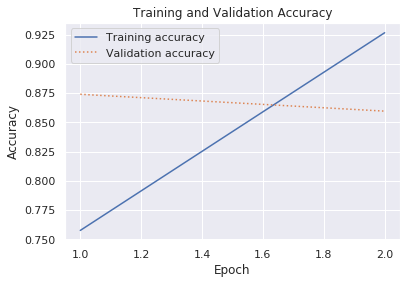

In [10]:
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

sns.set()
acc = hist.history['acc']
val = hist.history['val_acc']
epochs = range(1, len(acc) + 1)

plt.plot(epochs, acc, '-', label='Training accuracy')
plt.plot(epochs, val, ':', label='Validation accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(loc='upper left')
plt.plot()

In [11]:
model_json = model.to_json()
with open("model_ltsm.json", "w") as json_file:
    json_file.write(model_json)

model.save_weights("model_ltsm.h5")

In [13]:
from keras.models import model_from_json

In [15]:
json_file = open('model_sem.json', 'r')
loaded_model_json = json_file.read()
json_file.close()
loaded_model = model_from_json(loaded_model_json)
loaded_model.load_weights("model_sem.h5")

In [65]:
loaded_model.compile(loss='binary_crossentropy', optimizer='rmsprop', metrics=['accuracy'])
score = loaded_model.evaluate(x_test_t, y_test, verbose=0)
print("%s: %.2f%%" % (loaded_model.metrics_names[1], score[1]*100))

acc: 82.96%
